# Specifying graphs

```{admonition} Prerequisites

* [You have installed Flow](installing)
```

In this guide you will learn how to create a flow graph from a number of flow
node definitions. In the guide ["Writing nodes"](writing-nodes) you can learn
how to define your own nodes, in this guide we are going to use a number of
built-in flow nodes to construct a flow graph. We will also explore a few things
that can be done with the flow graph once it is constructed.

Specifying flow graphs is done with the `lang` module. The module responsible for the
language that describes flow nodes and flow graphs. We need one components from
this module:

* {py:func}`graph <flow.lang.composition.graph>`: a context-manager that creates
  a new {py:mod}`Model <flow.model.graph.Model>` and activates it such that it
  will be used in the `with` statement when nodes are instantiated. nodes for
  Python objects.

We import this component as follows:

In [1]:
from flow.lang import graph

## Node instantiation

A node is defined by the functionality it provides and the inputs and outputs it
has, much like a normal function. And where a function needs to be *called* for
it to be of any use, a *node* needs to be *instantiated*.

Node *instantiation* does two to three things:

1. It *creates a unique instance* for that node in the graph. The *instance*
   manages the live behavior of the node. It is what will be configured,
   connected, and updated during execution. The same node may be instantiated
   again for another part of the same graph. 
2. It *configures the node*, if necessary. Some node require an initial
   configuration, that may or may not be static throughout the execution.
3. Instantiation may partially *connect the inputs* of a node, but this is not
   mandatory.

## The first example

We are going to create a small data flow graph with a single *source* node that
streams values from a fixed sequence to a *sink* node that stores the sequence in
a list.

````{margin}
```{note}
The packages {py:mod}`flow.lib.gen` and {py:mod}`flow.lib.out` come with flow 
and offer a number of simple nodes to stream values into  and out of a data flow 
graph.
```
````

For the source node we will use {py:mod}`flow.lib.gen.values`, and for the sink
node we will use {py:mod}`flow.lib.out.sequence`.

To instantiate these we must call them, much like a constructor. The *positional
arguments* of such node constructors *may* be used to connect input channels.
This is optional, though. You can also choose to connect a node later.

Configuration of a node is always done with *keyword arguments*.

Let's examine the example:

In [2]:
from flow.lib import gen, out

output = []

with graph() as g:
    vs = gen.values(values=range(10))
    out.sequence(vs, out=output)

Resulting in this graph:

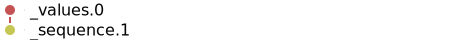

In [3]:
g

There are three things to note here. 

First, the nodes are constructed in a `with graph()` context. This creates a new
data flow graph, and makes sure that any newly created node is added there. The
data flow graph is made available in `g` and can be accessed later for
inspection or execution.

Second, the node constructed with the call to `gen.values` is captured in a
variable, `vs`. Later on we can use this variable to connect the output
of the node to other nodes.

Third, the call to `out.sequence` mixes connecting an input with configuration.
The variable `vs` is passed without a keyword and is thus treated as a streaming
input, and the variable `output` is passed *with* keyword and is treated as
configuration.


## The streaming operator `>>`

It happens very often that one node is only connected to the next which is again
connected to the next, and so on, making a kind of chain of nodes. It is
possible to write such chains by nesting the calls, but a more readable option
is to use the streaming operator `>>`. Our example becomes:

In [4]:
from flow.lib import gen, out

output = []

with graph() as g:
    gen.values(values=range(10)) >> out.sequence(out=output)

But the strength of this operator is demonstrated better when create a chain,
for example by taking the mean over a number of values:

In [5]:
from flow.lib import gen, arith, out

output = []

with graph() as g:
    gen.values(values=range(10)) >> arith.mean(windows={"vs":5}) >> out.sequence(out=output)

The windows configuration specifies that the *mean* is taken over each sequence
of 5 values. The next section explores *windowing* in more details.

## Windowing

A channel models a steady stream of values from one node to another. By default,
*Flow* assumes a node will produce and consumer a single value at a time from a
channel. This behavior can be modified with the `windows` node configuration
variable, a mapping from *port name* to *window size*.

The window size associated with a port specifies the number of items that will
be read or written from that port with each firing of the node. 

This means that a single channel has two window sizes, one for the producer and
one for the consumer. When the window sizes of producer and consumer differ the
firing rate will also differ by necessity. For example, when the producer writes
2 items and the consumer reads 4 items, the producer will fire 2 times for every
firing of the consumer.

```{note}
Currently *Flow* only supports a stride equal to the window size. A stride
specification could be used to consume fewer items than the window size from a 
channel making nodes that need historical data, like low-pass filters, possible.
```

## Stream bundles

Multiple channels can be grouped into a single object, called a *bundle*. Each
channel in a bundle is named, something that is used to connect bundles to
actors.

When you connect a bundle to an actor the port names of the actor will be used
to look-up channel names in the bundle, and only those will be connected.

````{margin}
```{note}
At the time of writing this guide, the nodes in this example do not actually exist, they are merely used to demonstrated the use of *bundles*.
```
````

Let's see how this work with an example. Suppose we have a simple graph that
rebalances the left and right channel of an audio file and plays it on a
speaker. The graph could look like this:

```py
@node(namespace=audio)
@dataclass
class rebalance:
  left: Sequence[float]
  right: Sequence[float]

  def __init__(self, left: Sequence[float], right: Sequence[float], 
               *, left_right: float=0) -> None:
      sf = 1-left_right if left_right>0 else 1
      xf = 0-left_right if left_right<0 else 0
      self.left  = [l*sf + r*xf for l, r in zip(left, right)]
      self.right = [l*xf + r*sf for l, r in zip(left, right)]

with graph() as g:
    wave.read("file.wav") >> audio.rebalance(left_right=0.8) >> audio.play()
```

Assuming the `wave.read` outputs a channel "*left*" and "*right*", this would
automatically connect those outputs to proper ports of the `rebalance` node,
and the same holds for the channel to `audio.play`.

## Manual bundle

It is possible to create a single bundle from multiple nodes using
{py:mod}`flow.lang.composition.bundle`:

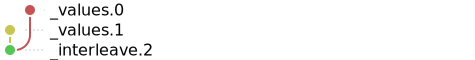

In [6]:
from flow.lang import bundle
from flow.lib import gen
from flow.lib.audio import wave

with graph() as g:
    l = gen.values(values=range(10))
    r = gen.values(values=range(10))
    bundle(left=l, right=r) >> wave.interleave()
g

## Renaming channels in a bundle

Sometimes the names of the channels do not match the names of the ports you want
to connect to, for example when using generic nodes. In those cases you can use
the convenience function {py:mod}`flow.lang.composition.rebundle` to create a
bundle with some channels renamed:

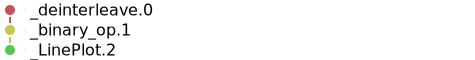

In [7]:
from flow.lang import rebundle
from flow.lib import plot, arith
from flow.lib.audio import wave

with graph() as g:
   wave.deinterleave() >> rebundle(a="left", b="right") >> arith.add() >> plot.line()
g

## Node views

When a node has many input or output channels, it is sometimes useful to select
the ones you want to connect. This can be achieved by indexing the node with the
names of the ports of interest. For example, `node["input1", "output2"]`, would
return a view on `node` with only the ports `input1` and `output2`.

At other times it is useful to create a view on a node but with different names
for the ports. The {py:func}`view <flow.lang.composition.Node.view>` method can
do what the `[]` operator can do *and* rename ports. It accepts a list of port
names to select, and keyword arguments that select a port, but with another
name.

Then there are the
{py:func}`inputs <flow.lang.composition.Node.inputs>` and
{py:func}`outputs <flow.lang.composition.Node.outputs>` methods give
a view with only the input and output ports. Of course, all of these methods 
are also available on the view itself.

## Connecting ports

So there is a plethora of choices in how to connect one port to another. This
section will give a short example of each choice and explain how it works.

### Straighforward connection

In [8]:
with graph() as g:
   gen.values(values=range(20)) >> plot.line().view()

The producer `gen.values` has a single output port and the consumer `plot.line`
has a single input port. Such 1:1 connections will be made regardless of the name.

### Producer port selection

In [9]:
with graph() as g:
   wave.deinterleave()["left"] >> plot.line()

The producer `wave.deinterleave` has a two output ports: *left* and *right*. The
consumer `plot.line` has a single input port, *values*. The `[]` operator
creates a view on `wave.deinterleave` with just a single port: *left*. The
connection to the input port of `plot.line` is made because this is also a 1:1
connection.

### Renaming with rebundle

In [10]:
with graph() as g:
   wave.deinterleave() >> rebundle(values="left") >> plot.line()

The producer `wave.deinterleave` has a two output ports: *left* and *right*. The
consumer `plot.line` has a single input port, *values*. The `rebundle` call creates
a new bundle from the outputs of `wave.deinterleave` where the channel `left` is
selected and renamed to `values`.

### Renaming with a producer view

In [11]:
with graph() as g:
   wave.deinterleave().view(left="values") >> plot.line()

The producer `wave.deinterleave` has a two output ports: *left* and *right*. The
consumer `plot.line` has a single input port, *values*. The call to `view`
creates a view of the producer where the output port `left` is renamed to
`values`, which nicely matches the input port of `plot.line`

### Renaming with a consumer view

In [12]:
with graph() as g:
   wave.deinterleave() >> plot.line().view(values="left")

The producer `wave.deinterleave` has a two output ports: *left* and *right*. The
consumer `plot.line` has a single input port, *values*. The call to `view`
creates a view of the consumer where the input port `values` is renamed to
`left`, which nicely matches the output port of `wave.deinterleave`.